<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/25_august_2021_fixes/C4/W4/assignment/C4_W4_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2021-09-09 19:02:41--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: 'daily-min-temperatures.csv'

     0K .......... .......... .......... .......... .......... 75% 4.08M 0s
    50K .......... ......                                     100% 34.4M=0.01s

2021-09-09 19:02:41 (5.22 MB/s) - 'daily-min-temperatures.csv' saved [67921/67921]



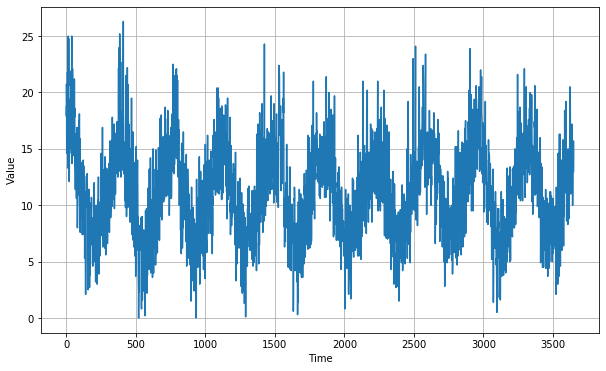

In [4]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 3s 122ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 1s 104ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 1s 100ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 1s 98ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 1s 99ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 1s 98ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 1s 97ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 1s 95ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 1s 98ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [==

10/10 [==============================] - 1s 104ms/step - loss: 5.1909 - mae: 5.6792
Epoch 85/100
10/10 [==============================] - 1s 106ms/step - loss: 5.5317 - mae: 6.0203
Epoch 86/100
10/10 [==============================] - 1s 99ms/step - loss: 6.5249 - mae: 7.0180
Epoch 87/100
10/10 [==============================] - 1s 98ms/step - loss: 7.2440 - mae: 7.7370
Epoch 88/100
10/10 [==============================] - 1s 98ms/step - loss: 8.0690 - mae: 8.5568
Epoch 89/100
10/10 [==============================] - 1s 100ms/step - loss: 16.8018 - mae: 17.2933
Epoch 90/100
10/10 [==============================] - 1s 102ms/step - loss: 38.7906 - mae: 39.2856
Epoch 91/100
10/10 [==============================] - 1s 105ms/step - loss: 25.5034 - mae: 26.0034
Epoch 92/100
10/10 [==============================] - 1s 99ms/step - loss: 29.9124 - mae: 30.4122
Epoch 93/100
10/10 [==============================] - 1s 98ms/step - loss: 32.1018 - mae: 32.6016
Epoch 94/100
10/10 [==================

[1e-08, 0.0001, 0, 60]

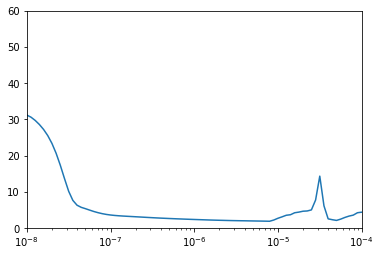

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)# YOUR CODE HERE)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 4s 49ms/step - loss: 9.9820 - mae: 10.4701
Epoch 2/150
25/25 [==============================] - 1s 48ms/step - loss: 2.5293 - mae: 2.9921
Epoch 3/150
25/25 [==============================] - 1s 49ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 1s 51ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 1s 53ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 2s 56ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 1s 52ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 1s 54ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 1s 52ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 2s 58ms/step - loss: 1.7000 - mae: 2.1483
Epoch 11/150
25/25 [============================

25/25 [==============================] - 1s 51ms/step - loss: 1.5061 - mae: 1.9475
Epoch 87/150
25/25 [==============================] - 1s 51ms/step - loss: 1.5074 - mae: 1.9489
Epoch 88/150
25/25 [==============================] - 1s 51ms/step - loss: 1.5053 - mae: 1.9467
Epoch 89/150
25/25 [==============================] - 1s 50ms/step - loss: 1.5050 - mae: 1.9463
Epoch 90/150
25/25 [==============================] - 1s 50ms/step - loss: 1.5064 - mae: 1.9479
Epoch 91/150
25/25 [==============================] - 1s 52ms/step - loss: 1.5055 - mae: 1.9468
Epoch 92/150
25/25 [==============================] - 1s 51ms/step - loss: 1.5045 - mae: 1.9459
Epoch 93/150
25/25 [==============================] - 1s 55ms/step - loss: 1.5032 - mae: 1.9445
Epoch 94/150
25/25 [==============================] - 2s 58ms/step - loss: 1.5023 - mae: 1.9437
Epoch 95/150
25/25 [==============================] - 1s 55ms/step - loss: 1.5110 - mae: 1.9529
Epoch 96/150
25/25 [==============================] -

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


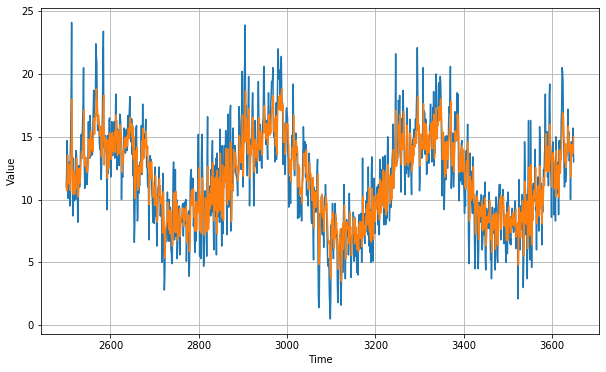

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796245

In [14]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.327581 10.70473  12.123895 ... 13.603757 13.795864 15.008175]
